#### Detection off-line version

The offline mode of detection, and has a filter following it.

In [34]:
# get data from the attack simulation file
import pandas as pd
import numpy as np

# Load spoofed snapshot
df = pd.read_csv("spoofed_lidar_snapshot.csv")
hit_distances = df["Distance"].to_numpy()
hit_labels = df["Label"].to_numpy()
ray_indices = np.arange(len(hit_distances))


In [40]:
num_rays = len(hit_distances)
window = 4                    # Wider neighborhood window
anomaly_threshold = 0.2       # Lowered slightly for tighter detection
global_real = hit_distances[(hit_labels == "real") & (hit_distances > 0)]

# Initialize new labels array (copied from original)
detected_labels = hit_labels.copy()

for i in range(num_rays):
    label = hit_labels[i]

    if label in ["real", "spoofed"]:  # spoofed and real both go through detection
        neighbors = []

        # Don't use 'spoofed' neighbors in the average
        for j in range(max(0, i - window), min(num_rays, i + window + 1)):
            if j != i and hit_labels[j] == "real" and hit_distances[j] > 0:
                neighbors.append(hit_distances[j])

        # Global fallback (only non-none)
        if len(neighbors) < 2:
            neighbors = hit_distances[(hit_labels == "real") & (hit_distances > 0)]

        if len(neighbors) > 0:
            local_avg = np.mean(neighbors)
            deviation = abs(hit_distances[i] - local_avg)

            if deviation > anomaly_threshold:
                detected_labels[i] = "detected"
                print(f"[YELLOW] Ray {i:02d} flagged as spoofed (dev = {deviation:.2f})")
            else:
                print(f"[GREEN] Ray {i:02d} OK (dev = {deviation:.2f})")
        else:
            print(f"[SKIP] Ray {i:02d}: no valid comparison data")

    elif label == "none":
        print(f"[GRAY] Ray {i:02d} missed")


[GREEN] Ray 00 OK (dev = 0.04)
[GREEN] Ray 01 OK (dev = 0.03)
[GREEN] Ray 02 OK (dev = 0.01)
[GREEN] Ray 03 OK (dev = 0.06)
[GRAY] Ray 04 missed
[GRAY] Ray 05 missed
[GRAY] Ray 06 missed
[GRAY] Ray 07 missed
[GRAY] Ray 08 missed
[GRAY] Ray 09 missed
[YELLOW] Ray 10 flagged as spoofed (dev = 0.73)
[YELLOW] Ray 11 flagged as spoofed (dev = 0.73)
[YELLOW] Ray 12 flagged as spoofed (dev = 0.73)
[YELLOW] Ray 13 flagged as spoofed (dev = 0.73)
[YELLOW] Ray 14 flagged as spoofed (dev = 0.73)
[GRAY] Ray 15 missed
[GRAY] Ray 16 missed
[GRAY] Ray 17 missed
[GRAY] Ray 18 missed
[GRAY] Ray 19 missed
[GRAY] Ray 20 missed
[GRAY] Ray 21 missed
[GRAY] Ray 22 missed
[GRAY] Ray 23 missed
[GRAY] Ray 24 missed
[GRAY] Ray 25 missed
[GRAY] Ray 26 missed
[GRAY] Ray 27 missed
[GRAY] Ray 28 missed
[GRAY] Ray 29 missed
[GRAY] Ray 30 missed
[GRAY] Ray 31 missed
[GRAY] Ray 32 missed
[GRAY] Ray 33 missed
[GRAY] Ray 34 missed
[GRAY] Ray 35 missed
[GRAY] Ray 36 missed
[GRAY] Ray 37 missed
[GRAY] Ray 38 missed
[GRAY]

In [41]:
# Store for use in before plotting
filtered_input = hit_distances.copy()
filtered_labels = detected_labels.copy()

In [42]:
import matplotlib.pyplot as plt

def clean_lidar(distances, labels, replace_strategy='mean', window=2, default_value=3.0):
    filtered = distances.copy()
    n = len(distances)
    for i in range(n):
        if labels[i] in ['detected', 'none']:
            neighbors = []
            for j in range(max(0, i - window), min(n, i + window + 1)):
                if j != i and labels[j] == 'real' and distances[j] > 0:
                    neighbors.append(distances[j])
            if replace_strategy == 'mean':
                filtered[i] = np.mean(neighbors) if neighbors else default_value
            elif replace_strategy == 'median':
                filtered[i] = np.median(neighbors) if neighbors else default_value
            elif replace_strategy == 'max':
                filtered[i] = default_value
            elif replace_strategy == 'drop':
                filtered[i] = np.nan
    return filtered

In [43]:
# Apply filter
filtered_output = clean_lidar(filtered_input, filtered_labels, replace_strategy='mean')
ray_indices = np.arange(len(filtered_input))


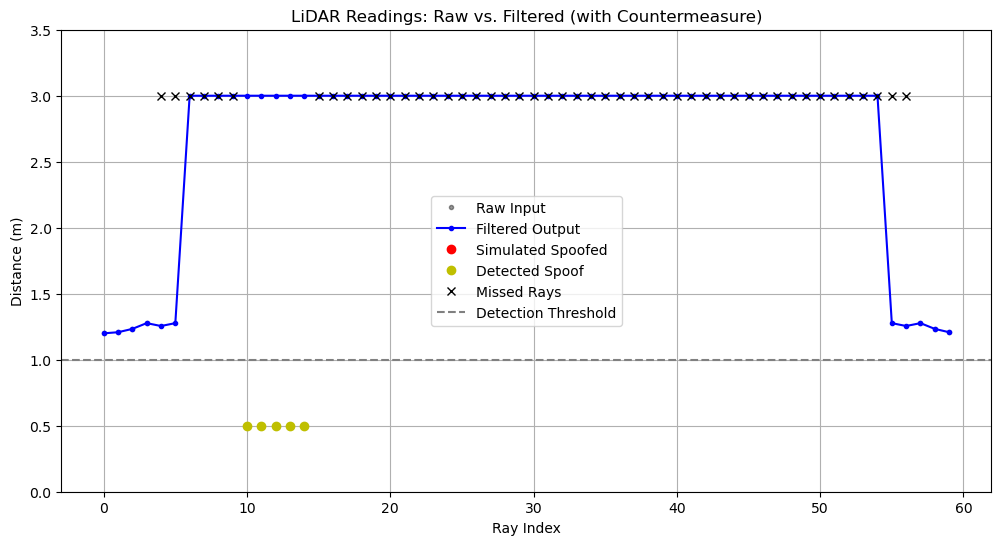

In [44]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(ray_indices, filtered_input, 'k.', alpha=0.4, label='Raw Input')
plt.plot(ray_indices, filtered_output, 'b.-', label='Filtered Output')

# Highlight spoofed and detected
plt.plot(ray_indices[np.array(hit_labels) == 'sim_spoof'], filtered_input[np.array(hit_labels) == 'sim_spoof'], 'ro', label='Simulated Spoofed')
plt.plot(ray_indices[np.array(filtered_labels) == 'detected'], filtered_input[np.array(filtered_labels) == 'detected'], 'yo', label='Detected Spoof')
plt.plot(ray_indices[np.array(hit_labels) == 'none'], [3.0]*np.sum(np.array(hit_labels) == 'none'), 'kx', label='Missed Rays')

plt.axhline(1.0, color='gray', linestyle='--', label='Detection Threshold')
plt.title("LiDAR Readings: Raw vs. Filtered (with Countermeasure)")
plt.xlabel("Ray Index")
plt.ylabel("Distance (m)")
plt.ylim(0, 3.5)
plt.grid(True)
plt.legend()
plt.show()

In [45]:
print("=== Raw vs Filtered Summary ===")
for i in range(num_rays):
    print(f"Ray {i:02d}: {hit_labels[i].ljust(10)} → Raw: {filtered_input[i]:.2f} → Filtered: {filtered_output[i]:.2f} → Final Label: {filtered_labels[i]}")


=== Raw vs Filtered Summary ===
Ray 00: real       → Raw: 1.20 → Filtered: 1.20 → Final Label: real
Ray 01: real       → Raw: 1.21 → Filtered: 1.21 → Final Label: real
Ray 02: real       → Raw: 1.23 → Filtered: 1.23 → Final Label: real
Ray 03: real       → Raw: 1.28 → Filtered: 1.28 → Final Label: real
Ray 04: none       → Raw: -1.00 → Filtered: 1.26 → Final Label: none
Ray 05: none       → Raw: -1.00 → Filtered: 1.28 → Final Label: none
Ray 06: none       → Raw: -1.00 → Filtered: 3.00 → Final Label: none
Ray 07: none       → Raw: -1.00 → Filtered: 3.00 → Final Label: none
Ray 08: none       → Raw: -1.00 → Filtered: 3.00 → Final Label: none
Ray 09: none       → Raw: -1.00 → Filtered: 3.00 → Final Label: none
Ray 10: spoofed    → Raw: 0.50 → Filtered: 3.00 → Final Label: detected
Ray 11: spoofed    → Raw: 0.50 → Filtered: 3.00 → Final Label: detected
Ray 12: spoofed    → Raw: 0.50 → Filtered: 3.00 → Final Label: detected
Ray 13: spoofed    → Raw: 0.50 → Filtered: 3.00 → Final Label: det

[GREEN] Ray 00 OK (local dev = 0.04, global dev = 0.03)
[GREEN] Ray 01 OK (local dev = 0.03, global dev = 0.03)
[GREEN] Ray 02 OK (local dev = 0.01, global dev = 0.00)
[GREEN] Ray 03 OK (local dev = 0.06, global dev = 0.04)
[GRAY] Ray 04 missed
[GRAY] Ray 05 missed
[GRAY] Ray 06 missed
[GRAY] Ray 07 missed
[GRAY] Ray 08 missed
[GRAY] Ray 09 missed
[YELLOW] Ray 10 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Ray 11 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Ray 12 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Ray 13 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[YELLOW] Ray 14 flagged as spoofed (local dev = 0.00, global dev = 0.73)
[GRAY] Ray 15 missed
[GRAY] Ray 16 missed
[GRAY] Ray 17 missed
[GRAY] Ray 18 missed
[GRAY] Ray 19 missed
[GRAY] Ray 20 missed
[GRAY] Ray 21 missed
[GRAY] Ray 22 missed
[GRAY] Ray 23 missed
[GRAY] Ray 24 missed
[GRAY] Ray 25 missed
[GRAY] Ray 26 missed
[GRAY] Ray 27 missed
[GRAY] Ray 2

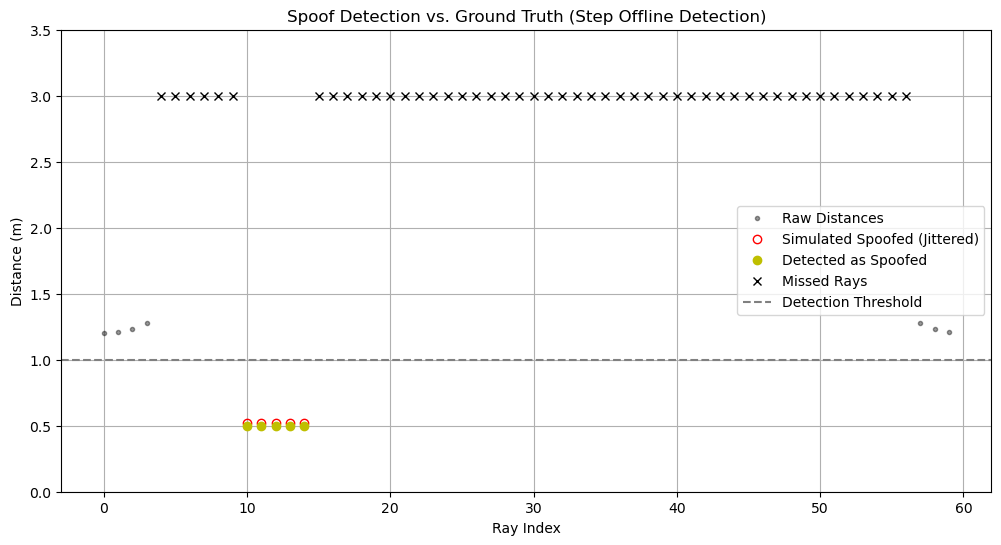

In [49]:
# adjust two show the red-spot (spoofed rays)
num_rays = len(hit_distances)
window = 4                       # Neighbor window size
local_threshold = 0.3            # Local deviation threshold
global_threshold = 0.4           # Global deviation threshold

# Compute global trusted average (only use distances > 1.0, exclude misses)
global_real_hits = hit_distances[hit_distances > 1.0]
global_avg = np.mean(global_real_hits) if len(global_real_hits) > 0 else 0

# Initialize detected_labels (to store detection result)
detected_labels = []

# === Detection Logic (Label-Free) ===
for i in range(num_rays):
    dist = hit_distances[i]

    if dist > 0:  # Only process rays that hit something (not misses)
        # Local neighbors (label-free)
        neighbors = []
        for j in range(max(0, i - window), min(num_rays, i + window + 1)):
            if j != i and hit_distances[j] > 0:
                neighbors.append(hit_distances[j])

        # Use global fallback if too few neighbors
        local_avg = np.mean(neighbors) if len(neighbors) >= 2 else global_avg

        # Calculate deviations
        local_dev = abs(dist - local_avg)
        global_dev = abs(dist - global_avg)

        # Detection decision (Hybrid logic)
        if (local_dev > local_threshold) or (global_dev > global_threshold):
            detected_labels.append("detected")
            print(f"[YELLOW] Ray {i:02d} flagged as spoofed (local dev = {local_dev:.2f}, global dev = {global_dev:.2f})")
        else:
            detected_labels.append("OK")
            print(f"[GREEN] Ray {i:02d} OK (local dev = {local_dev:.2f}, global dev = {global_dev:.2f})")
    else:
        detected_labels.append("none")  # Missed ray
        print(f"[GRAY] Ray {i:02d} missed")

# === Evaluation ===
evaluate_and_plot(hit_labels, detected_labels, hit_distances, step="Offline Detection")


In [48]:
import matplotlib.pyplot as plt

def evaluate_and_plot(hit_labels, detected_labels, hit_distances, step=None):
    hit_labels = np.array(hit_labels)
    detected_labels = np.array(detected_labels)
    hit_distances = np.array(hit_distances)
    ray_indices = np.arange(len(hit_distances))

    # === Evaluation ===
    TP = sum((hit_labels == "spoofed") & (detected_labels == "detected"))
    FP = sum((hit_labels == "real") & (detected_labels == "detected"))
    FN = sum((hit_labels == "spoofed") & (detected_labels != "detected"))
    TN = sum((hit_labels == "real") & (detected_labels != "detected"))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    print("=== Evaluation Summary ===")
    print(f"True Positives  (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Negatives  (TN): {TN}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")

    # === Plotting ===
    spoofed_mask = (hit_labels == "spoofed") | (hit_labels == "sim_spoof")
    real_mask = (hit_labels == "real")
    missed_mask = (hit_labels == "none")
    detected_mask = (detected_labels == "detected")

    plt.figure(figsize=(12, 6))
    plt.plot(ray_indices, hit_distances, 'k.', alpha=0.4, label='Raw Distances')

    plt.plot(ray_indices[spoofed_mask], hit_distances[spoofed_mask] + 0.02, 
             'ro', markerfacecolor='none', label='Simulated Spoofed (Jittered)')
    plt.plot(ray_indices[detected_mask], hit_distances[detected_mask], 
             'yo', label='Detected as Spoofed')
    plt.plot(ray_indices[missed_mask], [3.0] * np.sum(missed_mask), 
             'kx', label='Missed Rays')

    plt.axhline(1.0, color='gray', linestyle='--', label='Detection Threshold')
    
    if step is not None:
        plt.title(f"Spoof Detection vs. Ground Truth (Step {step})")
    else:
        plt.title("Spoof Detection vs. Ground Truth")
    plt.xlabel("Ray Index")
    plt.ylabel("Distance (m)")
    plt.ylim(0, 3.5)
    plt.legend()
    plt.grid(True)
    plt.show()
